In [42]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
import random
import tensorflow as tf
from tensorflow import keras

In [43]:
from google.colab import files

uploaded = files.upload()

Saving Australia_test_imputed copy.csv to Australia_test_imputed copy (6).csv
Saving Australia_train_imputed copy.csv to Australia_train_imputed copy (6).csv
Saving Brazil_test_imputed copy.csv to Brazil_test_imputed copy (6).csv
Saving Brazil_train_imputed copy.csv to Brazil_train_imputed copy (6).csv
Saving China_test_imputed copy.csv to China_test_imputed copy (6).csv
Saving China_train_imputed copy.csv to China_train_imputed copy (6).csv
Saving Germany_test_imputed copy.csv to Germany_test_imputed copy (6).csv
Saving Germany_train_imputed copy.csv to Germany_train_imputed copy (6).csv
Saving Nigeria_test_imputed copy.csv to Nigeria_test_imputed copy (6).csv
Saving Nigeria_train_imputed copy.csv to Nigeria_train_imputed copy (6).csv
Saving USA_test_imputed copy.csv to USA_test_imputed copy (6).csv
Saving USA_train_imputed copy.csv to USA_train_imputed copy (6).csv


In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
# Importing imputed data
USA_train_imputed = pd.read_csv("USA_train_imputed copy.csv")
USA_test_imputed = pd.read_csv("USA_test_imputed copy.csv")
USA_train_imputed.set_index('date', inplace=True)
USA_test_imputed.set_index('date', inplace=True)

Brazil_train_imputed = pd.read_csv("Brazil_train_imputed copy.csv")
Brazil_test_imputed = pd.read_csv("Brazil_test_imputed copy.csv")
Brazil_train_imputed.set_index('date', inplace=True)
Brazil_test_imputed.set_index('date', inplace=True)

Germany_train_imputed = pd.read_csv("Germany_train_imputed copy.csv")
Germany_test_imputed = pd.read_csv("Germany_test_imputed copy.csv")
Germany_train_imputed.set_index('date', inplace=True)
Germany_test_imputed.set_index('date', inplace=True)

Nigeria_train_imputed = pd.read_csv("Nigeria_train_imputed copy.csv")
Nigeria_test_imputed = pd.read_csv("Nigeria_test_imputed copy.csv")
Nigeria_train_imputed.set_index('date', inplace=True)
Nigeria_test_imputed.set_index('date', inplace=True)

China_train_imputed = pd.read_csv("China_train_imputed copy.csv")
China_test_imputed = pd.read_csv("China_test_imputed copy.csv")
China_train_imputed.set_index('date', inplace=True)
China_test_imputed.set_index('date', inplace=True)

Australia_train_imputed = pd.read_csv("Australia_train_imputed copy.csv")
Australia_test_imputed = pd.read_csv("Australia_test_imputed copy.csv")
Australia_train_imputed.set_index('date', inplace=True)
Australia_test_imputed.set_index('date', inplace=True)

# **USA model**
Dropping columns with constant values (low variance) and collinearity with new_cases, similar to previous model construction.

In [46]:
# Drop columns based on work from developing Prophet Multivariate model.
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
USA_train_imputed = USA_train_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
                                                      'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'hospital_beds_per_thousand',
                                                      'life_expectancy', 'human_development_index', 'location', 'continent', 'population',
                                                      'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                      'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
USA_train_imputed['new_cases_Lag_7'] = USA_train_imputed['new_cases_Lag_7'].fillna(0)
USA_train_imputed['new_cases_Lag_14'] = USA_train_imputed['new_cases_Lag_14'].fillna(0)
USA_train_imputed["Weekend"] = USA_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
USA_test_imputed = USA_test_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
                                                      'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'hospital_beds_per_thousand',
                                                      'life_expectancy', 'human_development_index', 'location', 'continent', 'population',
                                                      'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                      'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
USA_test_imputed['new_cases_Lag_7'][0:7] = USA_train_imputed['new_cases'][-7:]
USA_test_imputed['new_cases_Lag_14'][0:14] = USA_train_imputed['new_cases'][-14:]
USA_test_imputed["Weekend"] = USA_test_imputed["Weekend"].astype(int)

**Preparing the sequence data to make it in shape of (samples, time steps, features). Also normalizing the data to make it in similar scale. However, before doing so we want to save the mean and std dev for 'new_cases' for when we would like to un-normalize it for the model.**

In [47]:
new_cases_mean = USA_train_imputed['new_cases'].mean()
new_cases_std = USA_train_imputed['new_cases'].std()

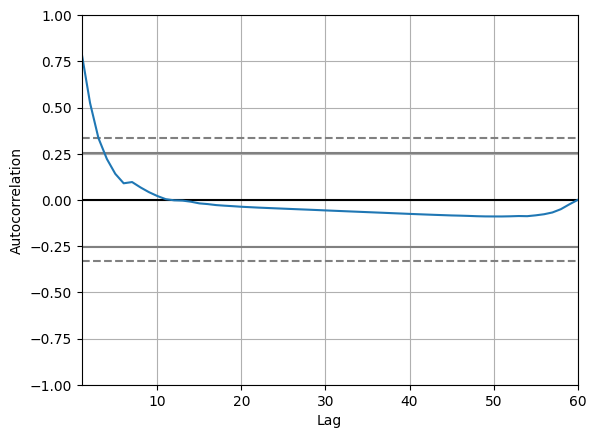

In [48]:
# Plot autocorrelation for a more reasonable number of lags
autocorrelation_plot(USA_train_imputed['new_cases'].iloc[:60])
plt.show()

# 7, 14, 30 and 60 look like a reasonable lag to capture weekly seasonality. The best one was 7. *___*

In [49]:
# Sequence and normalize the data

def process(df):
    lag7df = df.shift(7)
    #lag14df = df.shift(14)
    #lag30df = df.shift(30)
    lag7df.columns = ['lag7_' + str(col) for col in lag7df.columns]
    #lag14df.columns = ['lag14_' + str(col) for col in lag14df.columns]
    #lag30df.columns = ['lag30_' + str(col) for col in lag30df.columns]
    df = df[['new_cases']].join(lag7df)#.join(lag14df).join(lag30df)
    return df.fillna(0)

def normalize(df):
    for col in df.columns:
        # if col != 'new_cases':
        df[col]=(df[col]-df[col].mean())/df[col].std()
    return df

USA_train_imputed = process(USA_train_imputed)
USA_train_imputed = normalize(USA_train_imputed)
USA_test_imputed = process(USA_test_imputed)
USA_test_imputed = normalize(USA_test_imputed)

In [50]:
# Create make_series function which will give us shape of sequence
def make_series(df):
    series = []
    for i in range(len(df) - 7):
        subdf = df[i:i+7]
        series.append((subdf.index[-1], subdf['new_cases'].values[-1], subdf.drop('new_cases', axis=1).values))
    return series
train = make_series(USA_train_imputed)
test = make_series(USA_test_imputed)
print(train[0][0],train[0][1].shape,train[0][2].shape)

# In Professor Shi's code, '14' represents the number of days of data we are predicting for at a time.
# So you cannot predict for the first 14 days, only the 15th day will have the first predicted data.
# '12' in the example code refers to how many predictors you have
# Each prediction is based on the last 14 days. "Similar" to ARIMA's 7 thing

2020-01-28 () (7, 37)


In [51]:
# Model construction
from keras.models import Sequential
from keras.layers import LSTM, Dense

inputs = keras.layers.Input(shape=(7, 37))
lstm_out = keras.layers.LSTM(32)(inputs) # 32 is part of the LSTM structure. This is the number of units in the LSTM. The higher the number, the more complicated the nest. Potential for corss validation (ie. Grid or Randomized Search) for optimal hyperparamter tuning.
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7, 37)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                8960      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8993 (35.13 KB)
Trainable params: 8993 (35.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
# # Model construction
# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# inputs = keras.layers.Input(shape=(14, 148))
# lstm_out = keras.layers.LSTM(32)(inputs) # 32 is part of the LSTM structure. This is the number of units in the LSTM. The higher the number, the more complicated the nest. Potential for corss validation (ie. Grid or Randomized Search) for optimal hyperparamter tuning.
# outputs = keras.layers.Dense(1)(lstm_out)

# model = keras.Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")
# model.summary()


In [53]:
# Model construction continued. Used example values from Professor Shi's code for first batch test: learning_rate = 0.01, batch_size = 32, epochs = 100, sequence_length = 14
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

x=np.array([x[2].reshape(7,37) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=100,
    batch_size=32,
    shuffle=True,
)

(703, 7, 37)
(703,)
Epoch 1/100
22/22 [==============================] - 2s 3ms/step - loss: 0.3518
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1592
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1284
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1163
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0966
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1172
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0926
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0864
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0765
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0873
Epoch 11/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0843
Epoch 12/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0690
Epoch 13/100
22/2

## **Results**

In [54]:
train_pred = pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train])
train_pred.head()

22/22 [==============================] - 0s 2ms/step


,yhat
2020-01-28,-1.057010
2020-01-29,-1.059473
2020-01-30,-1.035547
2020-01-31,-1.034469
2020-02-01,-1.035740


In [55]:
# Denormalizing function
def denormalize(df, original_df):
    for col in df.columns:
      df[col] = df[col] * new_cases_std + new_cases_mean
      return df

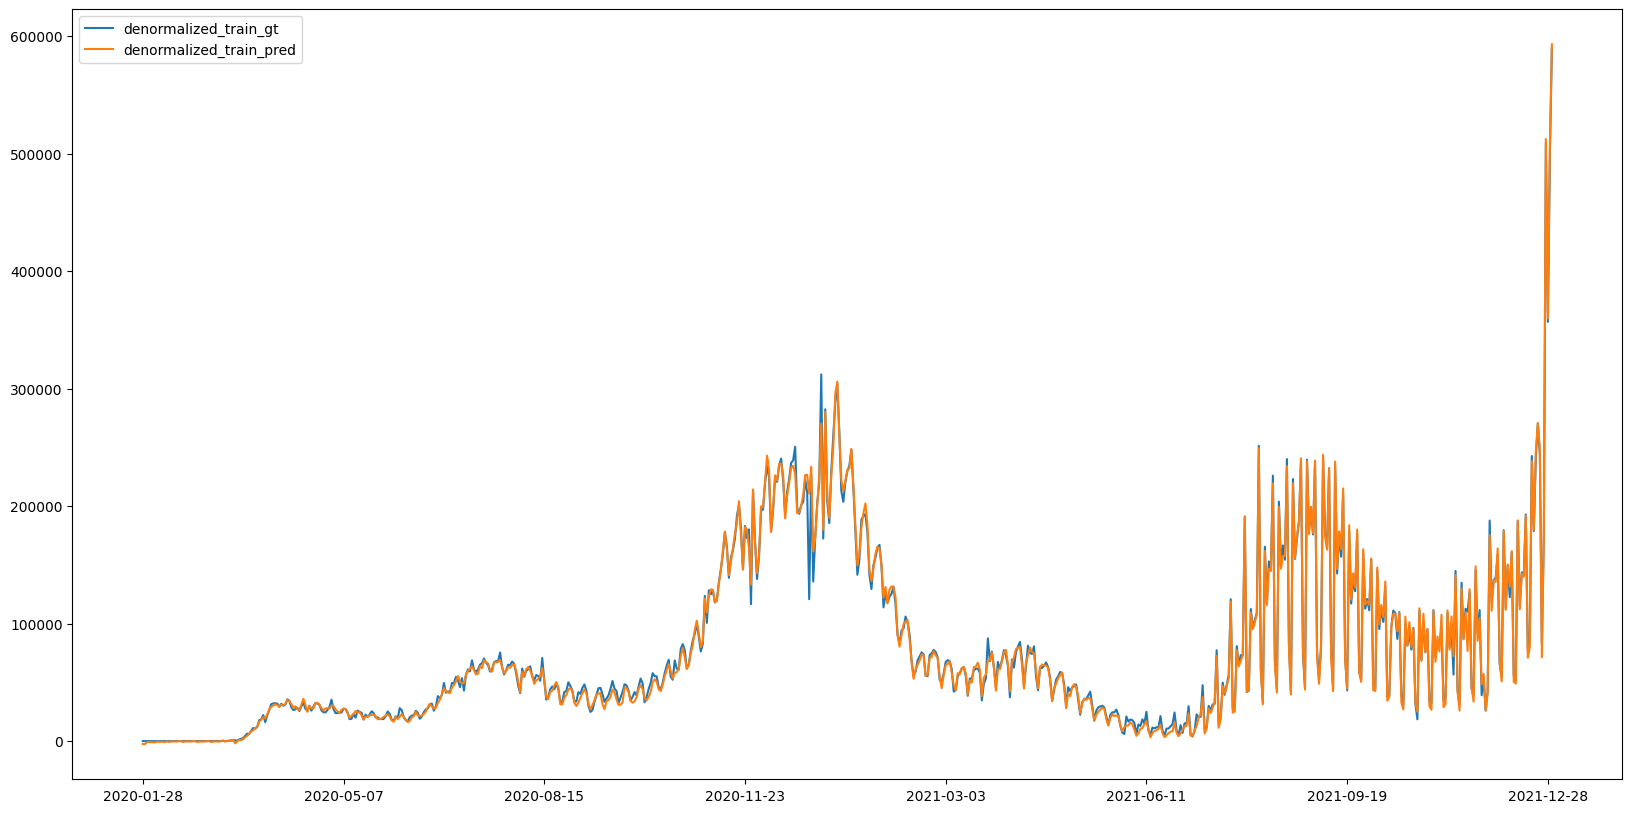

In [56]:
train_gt = pd.DataFrame(y, columns=['y'], index=[x[0] for x in train])

# Denormalize now
denormalized_train_pred = denormalize(train_pred, USA_train_imputed)
denormalized_train_gt = denormalize(train_gt, USA_train_imputed)

pd.concat([denormalized_train_gt, denormalized_train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['denormalized_train_gt', 'denormalized_train_pred'])

In [57]:
y_actual = denormalized_train_gt['y'].values
y_pred = denormalized_train_pred['yhat'].values

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("RMSE:", train_rmse)

RMSE: 5640.321040534904


2/2 [==============================] - 0s 5ms/step


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, '2022-02-23'),
  Text(0.0, 0, '2022-01-07'),
  Text(10.0, 0, '2022-01-17'),
  Text(20.0, 0, '2022-01-27'),
  Text(30.0, 0, '2022-02-06'),
  Text(40.0, 0, '2022-02-16'),
  Text(50.0, 0, '2022-02-26'),
  Text(60.0, 0, '')])

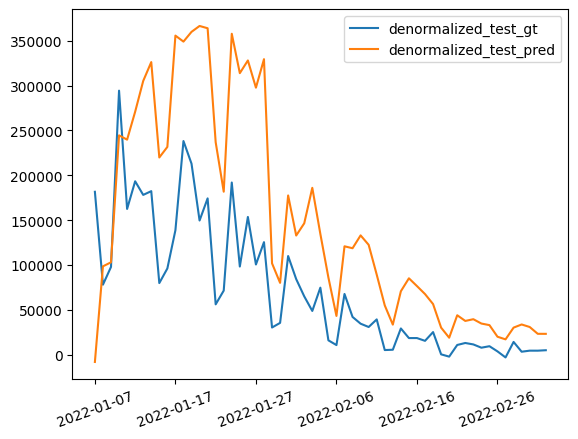

In [58]:
test_pred = model.predict(np.array([x[2].reshape(7,37) for x in test]))
test_pred = pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt = pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])

# Denormalize now
denormalized_test_pred = denormalize(test_pred, USA_test_imputed)
denormalized_test_gt = denormalize(test_gt, USA_test_imputed)

pd.concat([denormalized_test_gt, denormalized_test_pred], axis=1).plot()
plt.legend(['denormalized_test_gt', 'denormalized_test_pred'])
plt.xticks(rotation=20)

In [59]:
y_actual = denormalized_test_gt['y'].values
y_pred = denormalized_test_pred['yhat'].values

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("RMSE:", test_rmse)

RMSE: 104457.59305573335


# **Brazil model**
Dropping columns with constant values (low variance) and collinearity with new_cases, similar to previous model construction.

In [60]:
# Drop columns based on work from developing Prophet Multivariate model.
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
Brazil_train_imputed = Brazil_train_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
                                                            'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'hospital_beds_per_thousand',
                                                            'life_expectancy', 'human_development_index', 'population', 'location', 'continent',
                                                            'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Brazil_train_imputed['new_cases_Lag_7'] = Brazil_train_imputed['new_cases_Lag_7'].fillna(0)
Brazil_train_imputed['new_cases_Lag_14'] = Brazil_train_imputed['new_cases_Lag_14'].fillna(0)
Brazil_train_imputed["Weekend"] = Brazil_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
Brazil_test_imputed = Brazil_test_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
                                                          'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'hospital_beds_per_thousand',
                                                          'life_expectancy', 'human_development_index', 'population', 'location', 'continent',
                                                          'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                          'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
Brazil_test_imputed['new_cases_Lag_7'][0:7] = Brazil_train_imputed['new_cases'][-7:]
Brazil_test_imputed['new_cases_Lag_14'][0:14] = Brazil_train_imputed['new_cases'][-14:]
Brazil_test_imputed["Weekend"] = Brazil_test_imputed["Weekend"].astype(int)

In [61]:
new_cases_mean = Brazil_train_imputed['new_cases'].mean()
new_cases_std = Brazil_train_imputed['new_cases'].std()

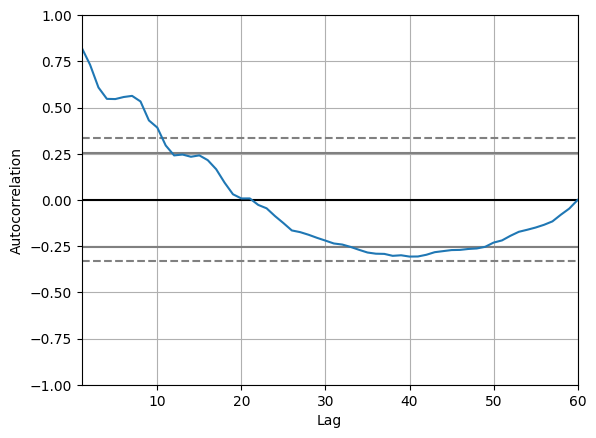

In [62]:
# Prepare for normalization and sequencing

# Plot autocorrelation for a more reasonable number of lags
autocorrelation_plot(Brazil_train_imputed['new_cases'].iloc[:60])
plt.show()

# 14 and 21 look like a reasonable lag to capture weekly seasonality. The best one was 14.

In [63]:
# Sequence and normalize the data

def process(df):
    #lag7df = df.shift(7)
    lag14df = df.shift(14)
    #lag30df = df.shift(30)
    #lag7df.columns = ['lag7_' + str(col) for col in lag7df.columns]
    lag14df.columns = ['lag14_' + str(col) for col in lag14df.columns]
    #lag21df.columns = ['lag30_' + str(col) for col in lag30df.columns]
    df = df[['new_cases']].join(lag14df)#.join(lag321df)
    return df.fillna(0)

def normalize(df):
    for col in df.columns:
        # if col != 'new_cases':
        df[col]=(df[col]-df[col].mean())/df[col].std()
    return df

Brazil_train_imputed = process(Brazil_train_imputed)
Brazil_train_imputed = normalize(Brazil_train_imputed)
Brazil_test_imputed = process(Brazil_test_imputed)
Brazil_test_imputed = normalize(Brazil_test_imputed)

In [64]:
# Create make_series function which will give us shape of sequence
def make_series(df):
    series = []
    for i in range(len(df) - 14):
        subdf = df[i:i+14]
        series.append((subdf.index[-1], subdf['new_cases'].values[-1], subdf.drop('new_cases', axis=1).values))
    return series
train = make_series(Brazil_train_imputed)
test = make_series(Brazil_test_imputed)
print(train[0][0],train[0][1].shape,train[0][2].shape)

2020-03-10 () (14, 25)


In [65]:
# Model construction
from keras.models import Sequential
from keras.layers import LSTM, Dense

inputs = keras.layers.Input(shape=(14, 25))
lstm_out = keras.layers.LSTM(32)(inputs) # 32 is part of the LSTM structure. This is the number of units in the LSTM. The higher the number, the more complicated the nest. Potential for corss validation (ie. Grid or Randomized Search) for optimal hyperparamter tuning.
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 14, 25)]          0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                7424      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7457 (29.13 KB)
Trainable params: 7457 (29.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
# Model construction continued. Used example values from Professor Shi's code for first batch test: learning_rate = 0.01, batch_size = 32, epochs = 100, sequence_length = 14
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

x=np.array([x[2].reshape(14,25) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=100,
    batch_size=32,
    shuffle=True,
)

(661, 14, 25)
(661,)
Epoch 1/100
21/21 [==============================] - 1s 5ms/step - loss: 0.3709
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 0.1700
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1321
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1201
Epoch 5/100
21/21 [==============================] - 0s 5ms/step - loss: 0.1116
Epoch 6/100
21/21 [==============================] - 0s 5ms/step - loss: 0.1153
Epoch 7/100
21/21 [==============================] - 0s 5ms/step - loss: 0.1062
Epoch 8/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0982
Epoch 9/100
21/21 [==============================] - 0s 6ms/step - loss: 0.0902
Epoch 10/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0953
Epoch 11/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0947
Epoch 12/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0891
Epoch 13/100
21/

In [67]:
train_pred = pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train])
train_pred.head()

21/21 [==============================] - 0s 2ms/step


,yhat
2020-03-10,-1.391256
2020-03-11,-1.380214
2020-03-12,-1.365561
2020-03-13,-1.364611
2020-03-14,-1.396581


In [68]:
# Denormalizing function
def denormalize(df, original_df):
    for col in df.columns:
      df[col] = df[col] * new_cases_std + new_cases_mean
      return df

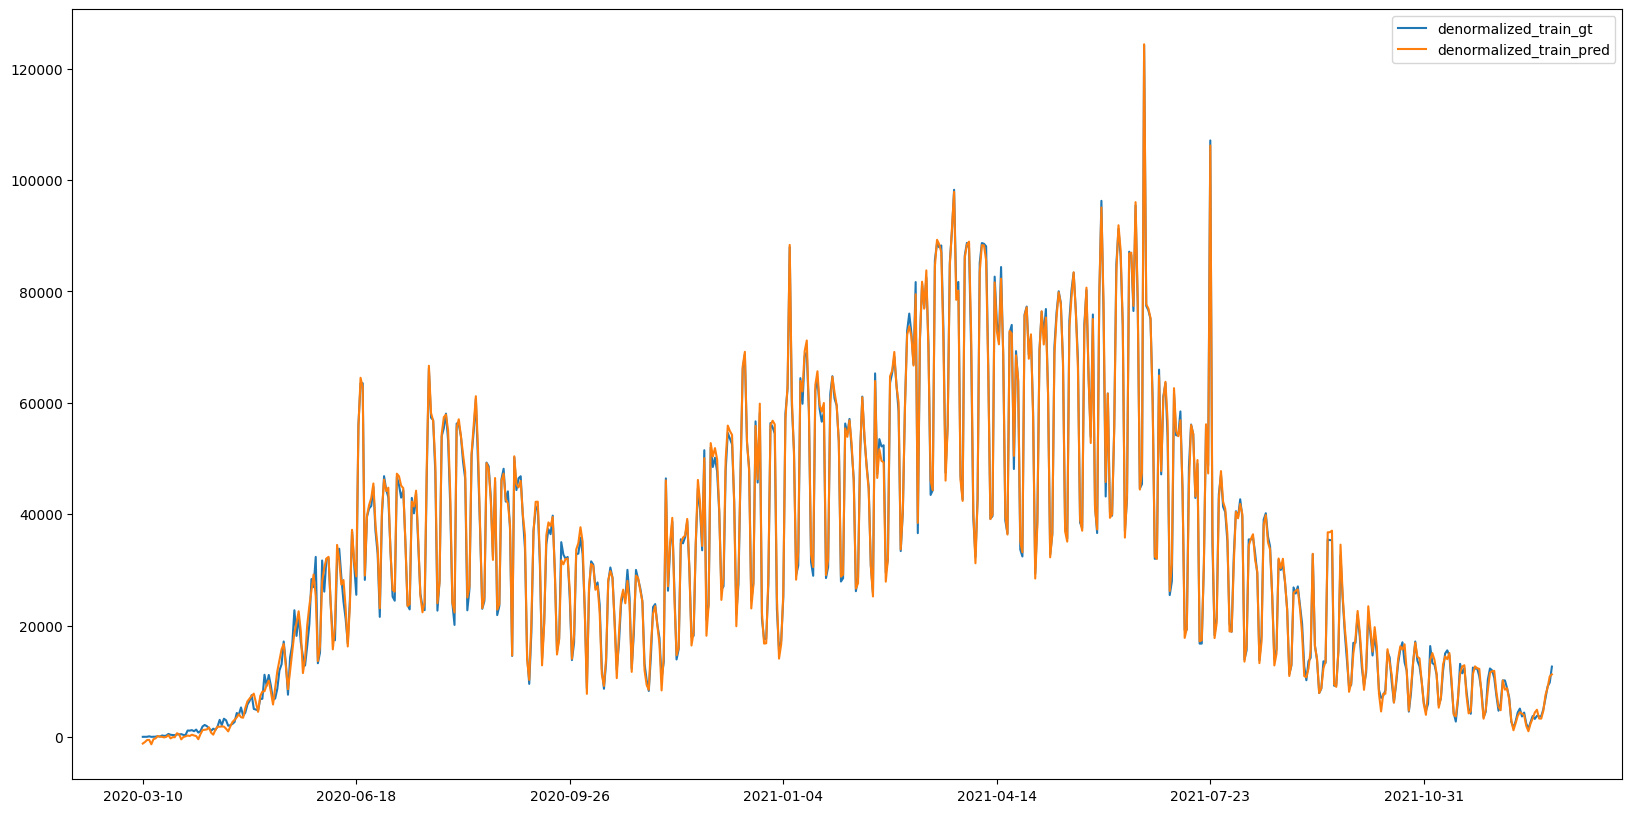

In [69]:
train_gt = pd.DataFrame(y, columns=['y'], index=[x[0] for x in train])

# Denormalize now
denormalized_train_pred = denormalize(train_pred, Brazil_train_imputed)
denormalized_train_gt = denormalize(train_gt, Brazil_train_imputed)

pd.concat([denormalized_train_gt, denormalized_train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['denormalized_train_gt', 'denormalized_train_pred'])

In [70]:
y_actual = denormalized_train_gt['y'].values
y_pred = denormalized_train_pred['yhat'].values

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("Train RMSE:", train_rmse)

Train RMSE: 1206.518354864459


2/2 [==============================] - 0s 4ms/step


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, '2022-02-23'),
  Text(0.0, 0, '2022-01-14'),
  Text(10.0, 0, '2022-01-24'),
  Text(20.0, 0, '2022-02-03'),
  Text(30.0, 0, '2022-02-13'),
  Text(40.0, 0, '2022-02-23'),
  Text(50.0, 0, ''),
  Text(60.0, 0, '')])

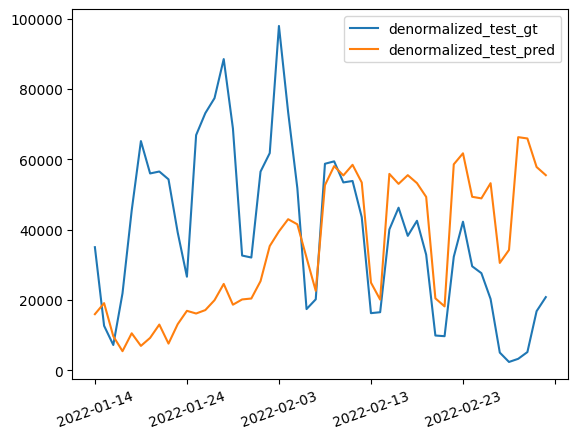

In [71]:
test_pred = model.predict(np.array([x[2].reshape(14,25) for x in test]))
test_pred = pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt = pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])

# Denormalize now
denormalized_test_pred = denormalize(test_pred, Brazil_test_imputed)
denormalized_test_gt = denormalize(test_gt, Brazil_test_imputed)

pd.concat([denormalized_test_gt, denormalized_test_pred], axis=1).plot()
plt.legend(['denormalized_test_gt', 'denormalized_test_pred'])
plt.xticks(rotation=20)

In [72]:
y_actual = denormalized_test_gt['y'].values
y_pred = denormalized_test_pred['yhat'].values

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 31976.103670584438


# **Germany model**
Dropping columns with constant values (low variance) and collinearity with new_cases, similar to previous model construction.

In [73]:
# Drop columns based on work from developing Prophet Multivariate model.
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
Germany_train_imputed = Germany_train_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
                                                              'gdp_per_capita', 'cardiovasc_death_rate', 'hospital_beds_per_thousand', 'population',
                                                              'life_expectancy', 'continent', 'location', 'human_development_index',
                                                              'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                              'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Germany_train_imputed['new_cases_Lag_7'] = Germany_train_imputed['new_cases_Lag_7'].fillna(0)
Germany_train_imputed['new_cases_Lag_14'] = Germany_train_imputed['new_cases_Lag_14'].fillna(0)
Germany_train_imputed["Weekend"] = Germany_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
Germany_test_imputed = Germany_test_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
                                                            'gdp_per_capita', 'cardiovasc_death_rate', 'hospital_beds_per_thousand', 'population',
                                                            'life_expectancy', 'continent', 'location', 'human_development_index',
                                                            'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
Germany_test_imputed['new_cases_Lag_7'][0:7] = Germany_train_imputed['new_cases'][-7:]
Germany_test_imputed['new_cases_Lag_14'][0:14] = Germany_train_imputed['new_cases'][-14:]
Germany_test_imputed["Weekend"] = Germany_test_imputed["Weekend"].astype(int)

In [74]:
new_cases_mean = Germany_train_imputed['new_cases'].mean()
new_cases_std = Germany_train_imputed['new_cases'].std()

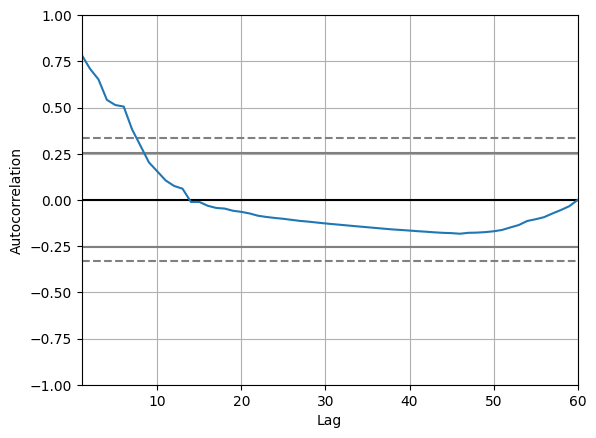

In [75]:
# Prepare for normalization and sequencing

# Plot autocorrelation for a more reasonable number of lags
autocorrelation_plot(Germany_train_imputed['new_cases'].iloc[:60])
plt.show()

# 7, 14, 30 and 60 look like a reasonable lag to capture weekly seasonality. The best one was 7.

In [76]:
# Sequence and normalize the data

def process(df):
    lag7df = df.shift(7)
    #lag14df = df.shift(14)
    #lag30df = df.shift(30)
    lag7df.columns = ['lag7_' + str(col) for col in lag7df.columns]
    #lag14df.columns = ['lag14_' + str(col) for col in lag14df.columns]
    #lag30df.columns = ['lag30_' + str(col) for col in lag30df.columns]
    df = df[['new_cases']].join(lag7df)#.join(lag14df).join(lag30df)
    return df.fillna(0)

def normalize(df):
    for col in df.columns:
        # if col != 'new_cases':
        df[col]=(df[col]-df[col].mean())/df[col].std()
    return df

Germany_train_imputed = process(Germany_train_imputed)
Germany_train_imputed = normalize(Germany_train_imputed)
Germany_test_imputed = process(Germany_test_imputed)
Germany_test_imputed = normalize(Germany_test_imputed)

In [77]:
# Create make_series function which will give us shape of sequence
def make_series(df):
    series = []
    for i in range(len(df) - 7):
        subdf = df[i:i+7]
        series.append((subdf.index[-1], subdf['new_cases'].values[-1], subdf.drop('new_cases', axis=1).values))
    return series
train = make_series(Germany_train_imputed)
test = make_series(Germany_test_imputed)
print(train[0][0],train[0][1].shape,train[0][2].shape)

2020-02-02 () (7, 31)


In [78]:
# Model construction
from keras.models import Sequential
from keras.layers import LSTM, Dense

inputs = keras.layers.Input(shape=(7, 31))
lstm_out = keras.layers.LSTM(32)(inputs) # 32 is part of the LSTM structure. This is the number of units in the LSTM. The higher the number, the more complicated the nest. Potential for corss validation (ie. Grid or Randomized Search) for optimal hyperparamter tuning.
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 7, 31)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                8192      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8225 (32.13 KB)
Trainable params: 8225 (32.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
# Model construction continued. Used example values from Professor Shi's code for first batch test: learning_rate = 0.01, batch_size = 32, epochs = 100, sequence_length = 14
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

x=np.array([x[2].reshape(7,31) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=100,
    batch_size=32,
    shuffle=True,
)

(698, 7, 31)
(698,)
Epoch 1/100
22/22 [==============================] - 1s 3ms/step - loss: 0.3334
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2045
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1818
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1906
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1589
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1641
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1579
Epoch 8/100
22/22 [==============================] - 0s 8ms/step - loss: 0.1657
Epoch 9/100
22/22 [==============================] - 0s 10ms/step - loss: 0.1624
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.1513
Epoch 11/100
22/22 [==============================] - 0s 3ms/step - loss: 0.1380
Epoch 12/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1314
Epoch 13/100
22/

In [80]:
train_pred = pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train])
train_pred.head()

22/22 [==============================] - 0s 1ms/step


,yhat
2020-02-02,-0.734591
2020-02-03,-0.712735
2020-02-04,-0.685345
2020-02-05,-0.746945
2020-02-06,-0.728172


In [81]:
# Denormalizing function
def denormalize(df, original_df):
    for col in df.columns:
      df[col] = df[col] * new_cases_std + new_cases_mean
      return df

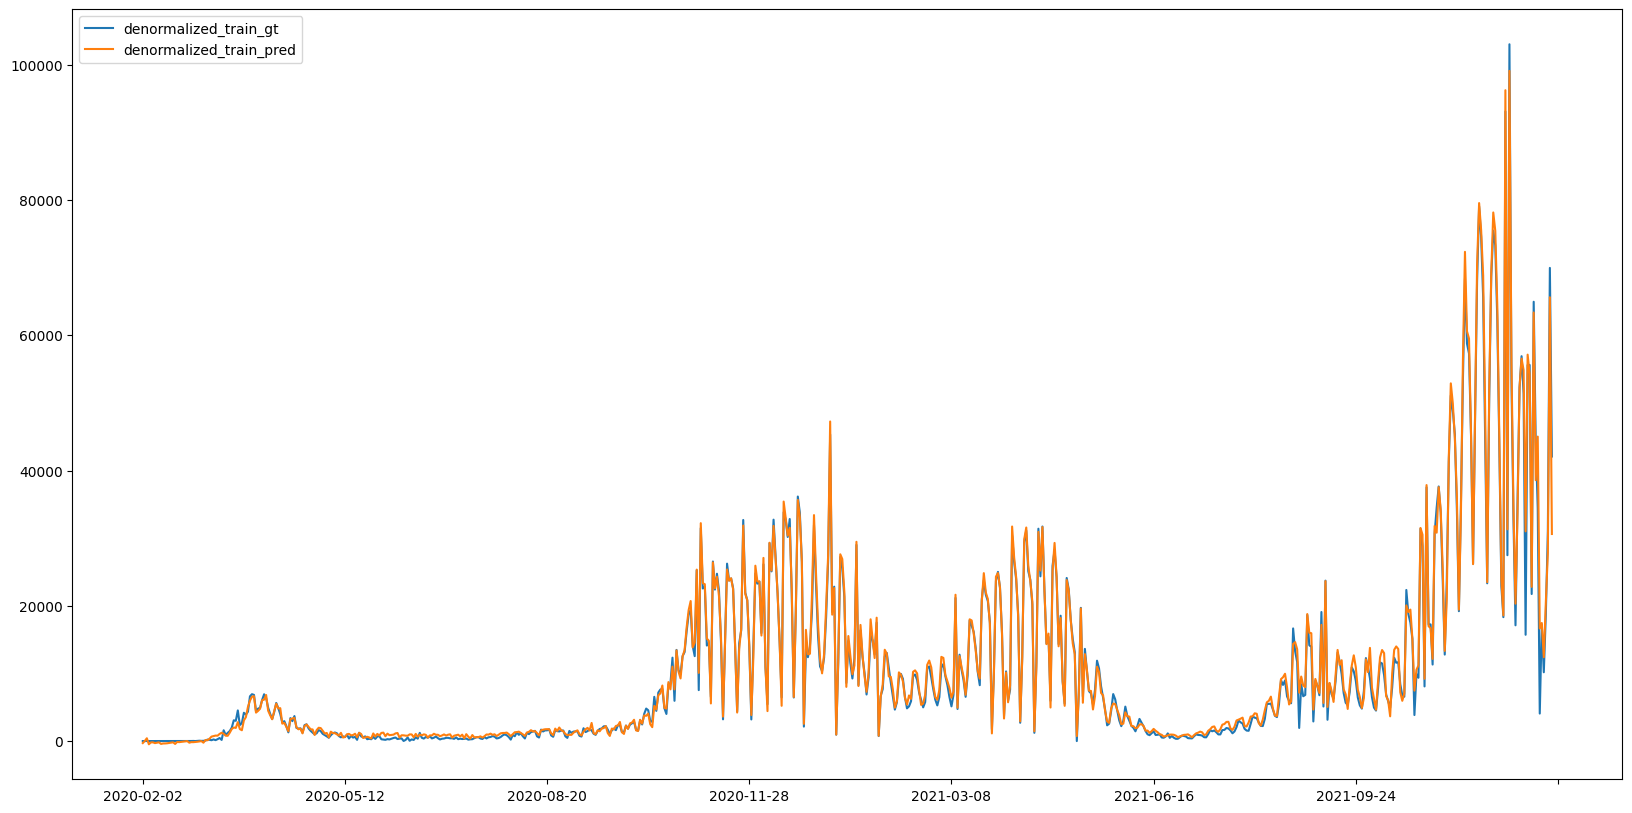

In [82]:
train_gt = pd.DataFrame(y, columns=['y'], index=[x[0] for x in train])

# Denormalize now
denormalized_train_pred = denormalize(train_pred, Germany_train_imputed)
denormalized_train_gt = denormalize(train_gt, Germany_train_imputed)

pd.concat([denormalized_train_gt, denormalized_train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['denormalized_train_gt', 'denormalized_train_pred'])

In [83]:
y_actual = denormalized_train_gt['y'].values
y_pred = denormalized_train_pred['yhat'].values

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("Train RMSE:", train_rmse)

Train RMSE: 1363.9908727919153


2/2 [==============================] - 0s 4ms/step


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, '2022-02-23'),
  Text(0.0, 0, '2022-01-07'),
  Text(10.0, 0, '2022-01-17'),
  Text(20.0, 0, '2022-01-27'),
  Text(30.0, 0, '2022-02-06'),
  Text(40.0, 0, '2022-02-16'),
  Text(50.0, 0, '2022-02-26'),
  Text(60.0, 0, '')])

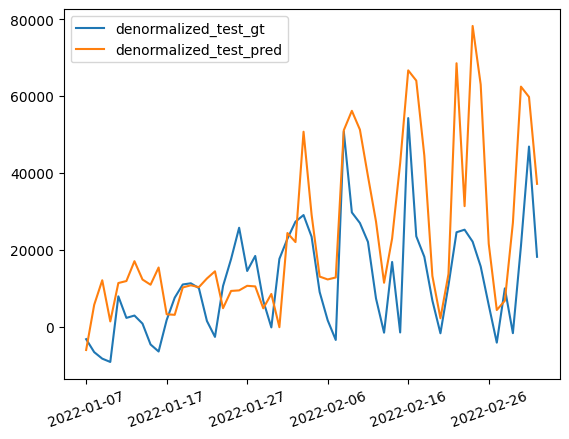

In [84]:
test_pred = model.predict(np.array([x[2].reshape(7,31) for x in test]))
test_pred = pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt = pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])

# Denormalize now
denormalized_test_pred = denormalize(test_pred, Germany_test_imputed)
denormalized_test_gt = denormalize(test_gt, Germany_test_imputed)

pd.concat([denormalized_test_gt, denormalized_test_pred], axis=1).plot()
plt.legend(['denormalized_test_gt', 'denormalized_test_pred'])
plt.xticks(rotation=20)

In [85]:
y_actual = denormalized_test_gt['y'].values
y_pred = denormalized_test_pred['yhat'].values

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 19432.119405758356


# **China model**
Dropping columns with constant values (low variance) and collinearity with new_cases, similar to previous model construction.

In [86]:
# Drop columns based on work from developing Prophet Multivariate model.
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
China_train_imputed = China_train_imputed.drop(columns = ['iso_code', 'population', 'population_density', 'median_age',
                                                          'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                                                          'cardiovasc_death_rate', 'life_expectancy', 'human_development_index',
                                                          'hospital_beds_per_thousand', 'continent', 'location',
                                                          'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                          'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
China_train_imputed['new_cases_Lag_7'] = China_train_imputed['new_cases_Lag_7'].fillna(0)
China_train_imputed['new_cases_Lag_14'] = China_train_imputed['new_cases_Lag_14'].fillna(0)
China_train_imputed["Weekend"] = China_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
China_test_imputed = China_test_imputed.drop(columns = ['iso_code', 'population', 'population_density', 'median_age',
                                                        'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                                                        'cardiovasc_death_rate', 'life_expectancy', 'human_development_index',
                                                        'hospital_beds_per_thousand', 'continent', 'location',
                                                        'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                        'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])


# Ensuring that the lag column values in test dataset are those of last values in train
China_test_imputed['new_cases_Lag_7'][0:7] = China_train_imputed['new_cases'][-7:]
China_test_imputed['new_cases_Lag_14'][0:14] = China_train_imputed['new_cases'][-14:]
China_test_imputed["Weekend"] = China_test_imputed["Weekend"].astype(int)

In [87]:
new_cases_mean = China_train_imputed['new_cases'].mean()
new_cases_std = China_train_imputed['new_cases'].std()

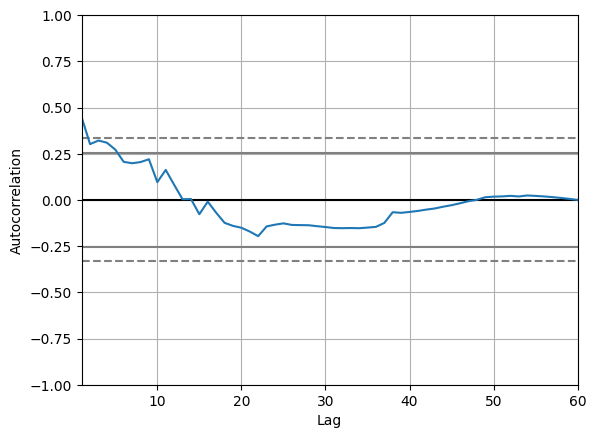

In [88]:
# Prepare for normalization and sequencing

# Plot autocorrelation for a more reasonable number of lags
autocorrelation_plot(China_train_imputed['new_cases'].iloc[:60])
plt.show()

# 14, 21, 30 and 60 look like a reasonable lag to capture biweekly, triweekly or monthly seasonality. The best one was 14.

In [89]:
# Sequence and normalize the data

def process(df):
    #lag7df = df.shift(7)
    lag14df = df.shift(14)
    #lag30df = df.shift(30)
    #lag7df.columns = ['lag7_' + str(col) for col in lag7df.columns]
    lag14df.columns = ['lag14_' + str(col) for col in lag14df.columns]
    #lag30df.columns = ['lag30_' + str(col) for col in lag30df.columns]
    df = df[['new_cases']].join(lag14df)#.join(lag30df)
    return df.fillna(0)

def normalize(df):
    for col in df.columns:
        # if col != 'new_cases':
        df[col]=(df[col]-df[col].mean())/df[col].std()
    return df

China_train_imputed = process(China_train_imputed)
China_train_imputed = normalize(China_train_imputed)
China_test_imputed = process(China_test_imputed)
China_test_imputed = normalize(China_test_imputed)

In [90]:
# Create make_series function which will give us shape of sequence
def make_series(df):
    series = []
    for i in range(len(df) - 14):
        subdf = df[i:i+14]
        series.append((subdf.index[-1], subdf['new_cases'].values[-1], subdf.drop('new_cases', axis=1).values))
    return series
train = make_series(China_train_imputed)
test = make_series(China_test_imputed)
print(train[0][0],train[0][1].shape,train[0][2].shape)

2020-02-04 () (14, 17)


In [93]:
# Model construction
from keras.models import Sequential
from keras.layers import LSTM, Dense

inputs = keras.layers.Input(shape=(14, 17))
lstm_out = keras.layers.LSTM(32)(inputs) # 32 is part of the LSTM structure. This is the number of units in the LSTM. The higher the number, the more complicated the nest. Potential for corss validation (ie. Grid or Randomized Search) for optimal hyperparamter tuning.
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 14, 17)]          0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                6400      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6433 (25.13 KB)
Trainable params: 6433 (25.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
# Model construction continued. Used example values from Professor Shi's code for first batch test: learning_rate = 0.01, batch_size = 32, epochs = 100, sequence_length = 14
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

x=np.array([x[2].reshape(14,17) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=100,
    batch_size=32,
    shuffle=True,
)

(696, 14, 17)
(696,)
Epoch 1/100
22/22 [==============================] - 3s 5ms/step - loss: 0.6301
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.4853
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 0.4445
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.4244
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.4255
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.4052
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.4011
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 0.4457
Epoch 9/100
22/22 [==============================] - 0s 8ms/step - loss: 0.4450
Epoch 10/100
22/22 [==============================] - 0s 6ms/step - loss: 0.4079
Epoch 11/100
22/22 [==============================] - 0s 5ms/step - loss: 0.4048
Epoch 12/100
22/22 [==============================] - 0s 6ms/step - loss: 0.3719
Epoch 13/100
22/

In [95]:
train_pred = pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train])
train_pred.head()

22/22 [==============================] - 0s 2ms/step


,yhat
2020-02-04,4.960701
2020-02-05,4.653708
2020-02-06,4.102502
2020-02-07,4.519521
2020-02-08,3.325403


In [96]:
# Denormalizing function
def denormalize(df, original_df):
    for col in df.columns:
      df[col] = df[col] * new_cases_std + new_cases_mean
      return df

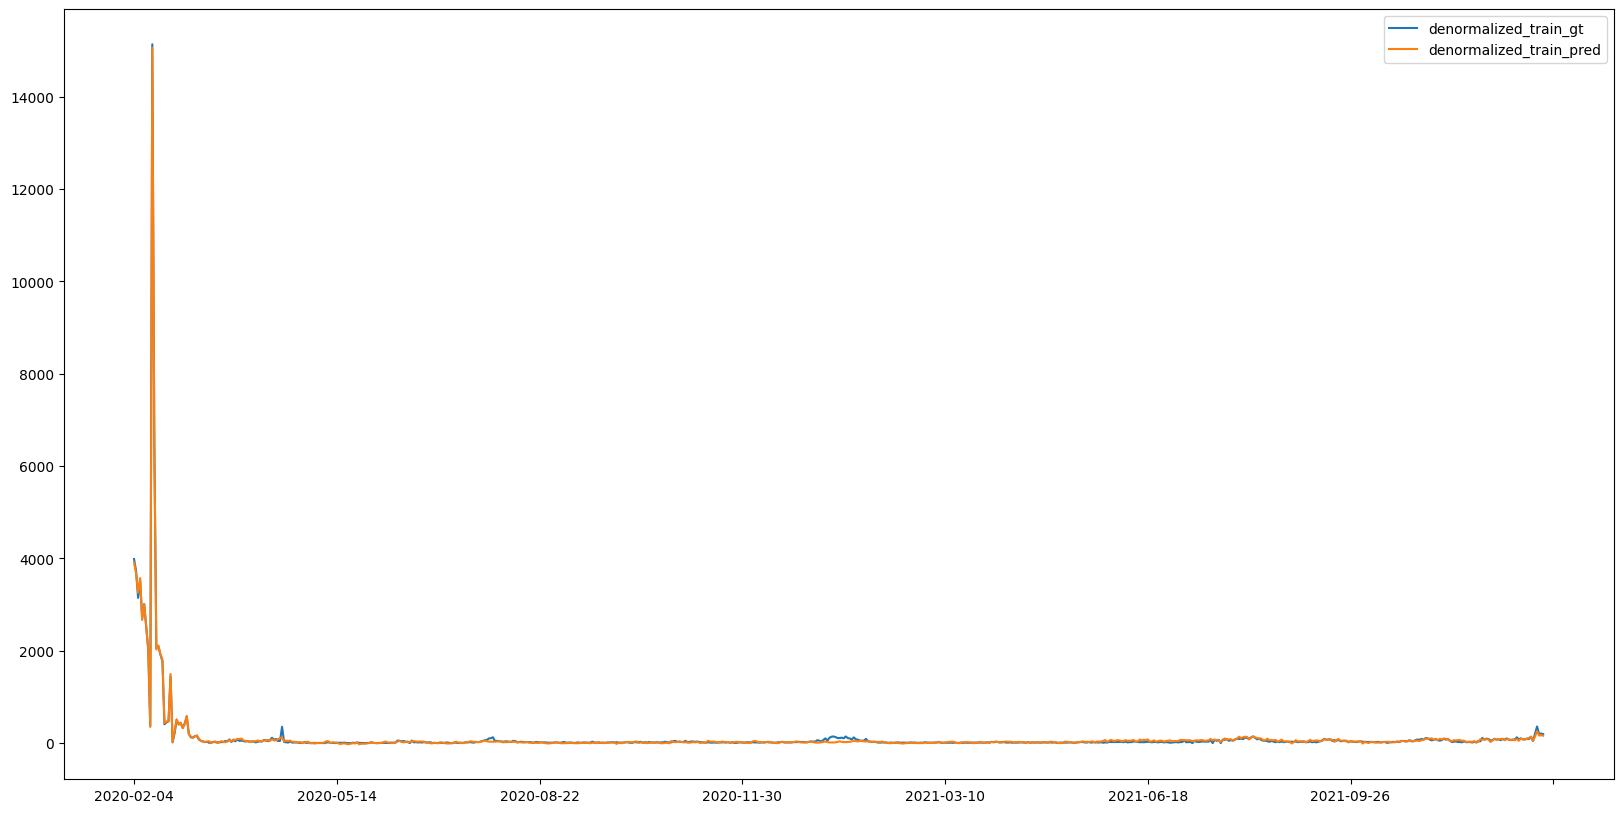

In [97]:
train_gt = pd.DataFrame(y, columns=['y'], index=[x[0] for x in train])

# Denormalize now
denormalized_train_pred = denormalize(train_pred, China_train_imputed)
denormalized_train_gt = denormalize(train_gt, China_train_imputed)

pd.concat([denormalized_train_gt, denormalized_train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['denormalized_train_gt', 'denormalized_train_pred'])

In [98]:
y_actual = denormalized_train_gt['y'].values
y_pred = denormalized_train_pred['yhat'].values

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("Train RMSE:", train_rmse)

Train RMSE: 26.153510073208675


2/2 [==============================] - 0s 6ms/step


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, '2022-02-23'),
  Text(0.0, 0, '2022-01-14'),
  Text(10.0, 0, '2022-01-24'),
  Text(20.0, 0, '2022-02-03'),
  Text(30.0, 0, '2022-02-13'),
  Text(40.0, 0, '2022-02-23'),
  Text(50.0, 0, ''),
  Text(60.0, 0, '')])

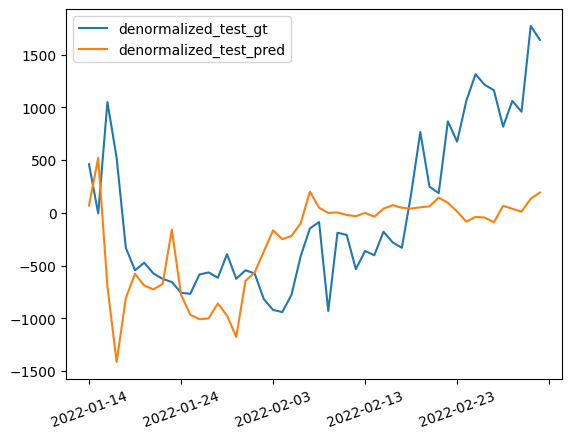

In [100]:
test_pred = model.predict(np.array([x[2].reshape(14,17) for x in test]))
test_pred = pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt = pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])

# Denormalize now
denormalized_test_pred = denormalize(test_pred, China_test_imputed)
denormalized_test_gt = denormalize(test_gt, China_test_imputed)

pd.concat([denormalized_test_gt, denormalized_test_pred], axis=1).plot()
plt.legend(['denormalized_test_gt', 'denormalized_test_pred'])
plt.xticks(rotation=20)

In [101]:
y_actual = denormalized_test_gt['y'].values
y_pred = denormalized_test_pred['yhat'].values

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 743.6583978352525


# **Nigeria model**
Dropping columns with constant values (low variance) and collinearity with new_cases, similar to previous model construction.

In [102]:
# Drop columns based on work from developing Prophet Multivariate model.
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
Nigeria_train_imputed = Nigeria_train_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
                                                              'gdp_per_capita', 'cardiovasc_death_rate', 'handwashing_facilities', 'life_expectancy',
                                                              'human_development_index', 'population', 'location', 'continent',
                                                              'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                              'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Nigeria_train_imputed['new_cases_Lag_7'] = Nigeria_train_imputed['new_cases_Lag_7'].fillna(0)
Nigeria_train_imputed['new_cases_Lag_14'] = Nigeria_train_imputed['new_cases_Lag_14'].fillna(0)
Nigeria_train_imputed["Weekend"] = Nigeria_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
Nigeria_test_imputed = Nigeria_test_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
                                                            'gdp_per_capita', 'cardiovasc_death_rate', 'handwashing_facilities', 'life_expectancy',
                                                            'human_development_index', 'population', 'location', 'continent',
                                                            'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
Nigeria_test_imputed['new_cases_Lag_7'][0:7] = Nigeria_train_imputed['new_cases'][-7:]
Nigeria_test_imputed['new_cases_Lag_14'][0:14] = Nigeria_train_imputed['new_cases'][-14:]
Nigeria_test_imputed["Weekend"] = Nigeria_test_imputed["Weekend"].astype(int)

In [103]:
new_cases_mean = Nigeria_train_imputed['new_cases'].mean()
new_cases_std = Nigeria_train_imputed['new_cases'].std()

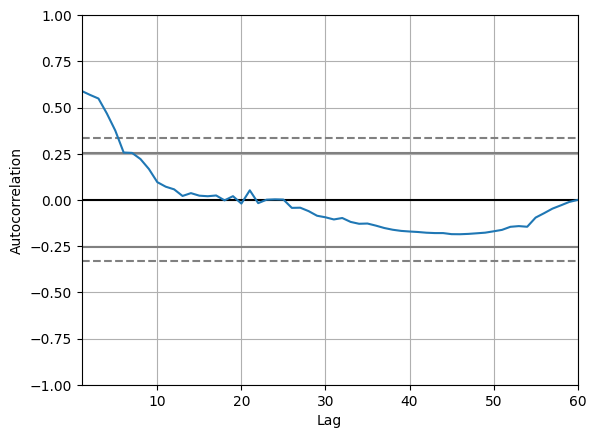

In [104]:
# Prepare for normalization and sequencing

# Plot autocorrelation for a more reasonable number of lags
autocorrelation_plot(Nigeria_train_imputed['new_cases'].iloc[:60])
plt.show()

# 7, 14, 30 and 60 look like a reasonable lag to capture weekly seasonality. The best one was 7.

In [105]:
# Sequence and normalize the data

def process(df):
    lag7df = df.shift(7)
    #lag14df = df.shift(14)
    #lag30df = df.shift(30)
    lag7df.columns = ['lag7_' + str(col) for col in lag7df.columns]
    #lag14df.columns = ['lag14_' + str(col) for col in lag14df.columns]
    #lag30df.columns = ['lag30_' + str(col) for col in lag30df.columns]
    df = df[['new_cases']].join(lag7df)#.join(lag14df).join(lag30df)
    return df.fillna(0)

def normalize(df):
    for col in df.columns:
        # if col != 'new_cases':
        df[col]=(df[col]-df[col].mean())/df[col].std()
    return df

Nigeria_train_imputed = process(Nigeria_train_imputed)
Nigeria_train_imputed = normalize(Nigeria_train_imputed)
Nigeria_test_imputed = process(Nigeria_test_imputed)
Nigeria_test_imputed = normalize(Nigeria_test_imputed)

In [106]:
# Create make_series function which will give us shape of sequence
def make_series(df):
    series = []
    for i in range(len(df) - 7):
        subdf = df[i:i+7]
        series.append((subdf.index[-1], subdf['new_cases'].values[-1], subdf.drop('new_cases', axis=1).values))
    return series
train = make_series(Nigeria_train_imputed)
test = make_series(Nigeria_test_imputed)
print(train[0][0],train[0][1].shape,train[0][2].shape)

2020-03-05 () (7, 20)


In [107]:
# Model construction
from keras.models import Sequential
from keras.layers import LSTM, Dense

inputs = keras.layers.Input(shape=(7, 20))
lstm_out = keras.layers.LSTM(32)(inputs) # 32 is part of the LSTM structure. This is the number of units in the LSTM. The higher the number, the more complicated the nest. Potential for corss validation (ie. Grid or Randomized Search) for optimal hyperparamter tuning.
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 7, 20)]           0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                6784      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6817 (26.63 KB)
Trainable params: 6817 (26.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [108]:
# Model construction continued. Used example values from Professor Shi's code for first batch test: learning_rate = 0.01, batch_size = 32, epochs = 100, sequence_length = 14
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

x=np.array([x[2].reshape(7,20) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=100,
    batch_size=32,
    shuffle=True,
)

(666, 7, 20)
(666,)
Epoch 1/100
21/21 [==============================] - 1s 4ms/step - loss: 0.5249
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3863
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.3477
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3327
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.3362
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.3305
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 0.3228
Epoch 8/100
21/21 [==============================] - 0s 7ms/step - loss: 0.3103
Epoch 9/100
21/21 [==============================] - 0s 6ms/step - loss: 0.3038
Epoch 10/100
21/21 [==============================] - 0s 7ms/step - loss: 0.3169
Epoch 11/100
21/21 [==============================] - 0s 7ms/step - loss: 0.2944
Epoch 12/100
21/21 [==============================] - 0s 6ms/step - loss: 0.2918
Epoch 13/100
21/2

In [109]:
train_pred = pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train])
train_pred.head()

21/21 [==============================] - 0s 2ms/step


,yhat
2020-03-05,-0.622001
2020-03-06,-0.697016
2020-03-07,-0.761819
2020-03-08,-0.737846
2020-03-09,-0.756604


In [110]:
# Denormalizing function
def denormalize(df, original_df):
    for col in df.columns:
      df[col] = df[col] * new_cases_std + new_cases_mean
      return df

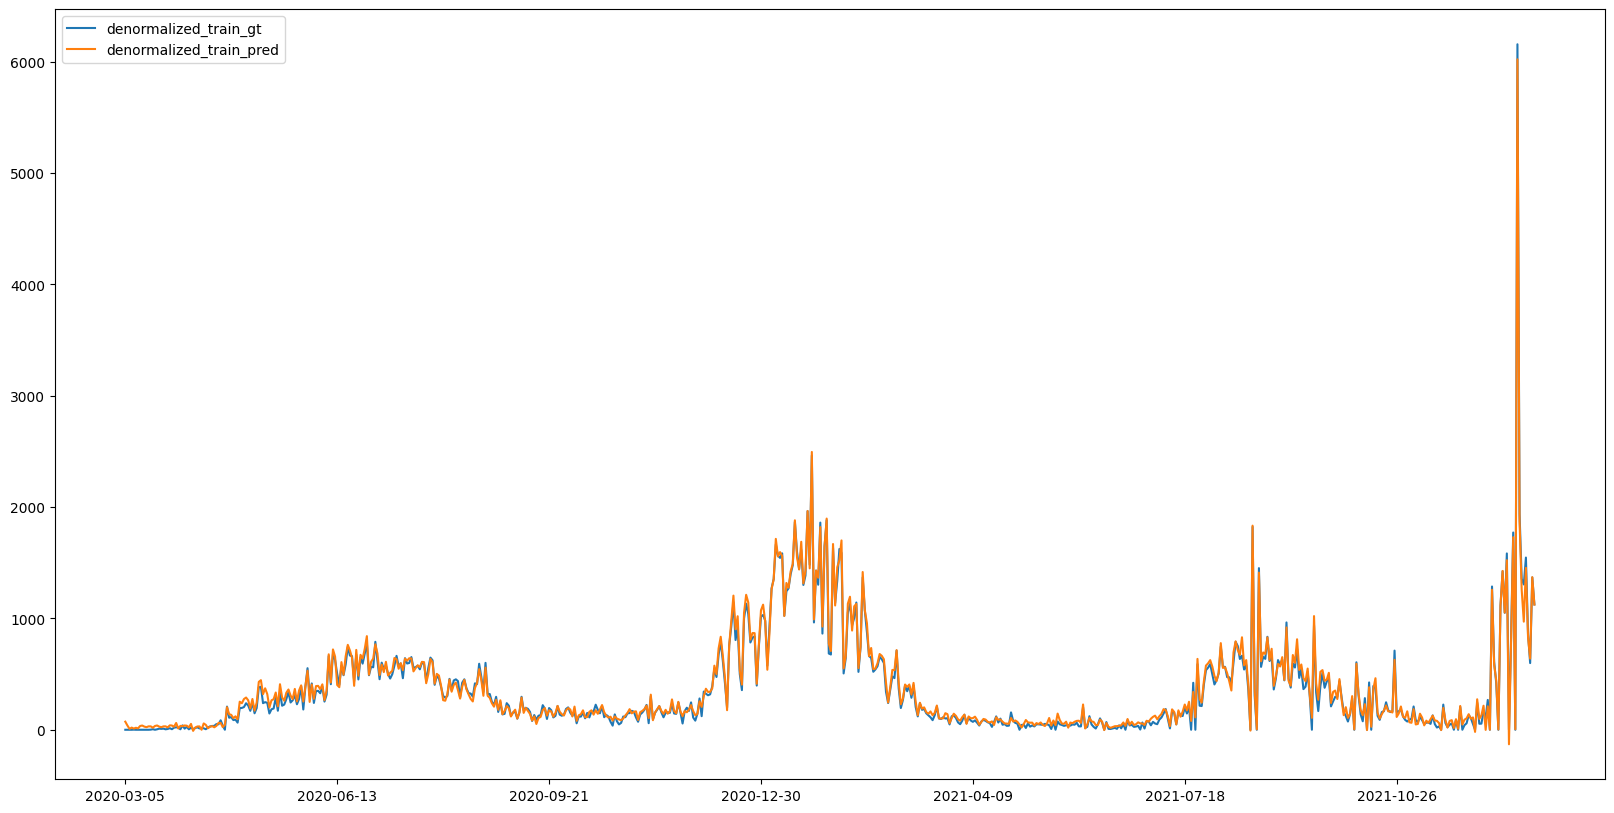

In [111]:
train_gt = pd.DataFrame(y, columns=['y'], index=[x[0] for x in train])

# Denormalize now
denormalized_train_pred = denormalize(train_pred, Nigeria_train_imputed)
denormalized_train_gt = denormalize(train_gt, Nigeria_train_imputed)

pd.concat([denormalized_train_gt, denormalized_train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['denormalized_train_gt', 'denormalized_train_pred'])

In [112]:
y_actual = denormalized_train_gt['y'].values
y_pred = denormalized_train_pred['yhat'].values

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("Train RMSE:", train_rmse)

Train RMSE: 41.98109586718019


2/2 [==============================] - 0s 3ms/step


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, '2022-02-23'),
  Text(0.0, 0, '2022-01-07'),
  Text(10.0, 0, '2022-01-17'),
  Text(20.0, 0, '2022-01-27'),
  Text(30.0, 0, '2022-02-06'),
  Text(40.0, 0, '2022-02-16'),
  Text(50.0, 0, '2022-02-26'),
  Text(60.0, 0, '')])

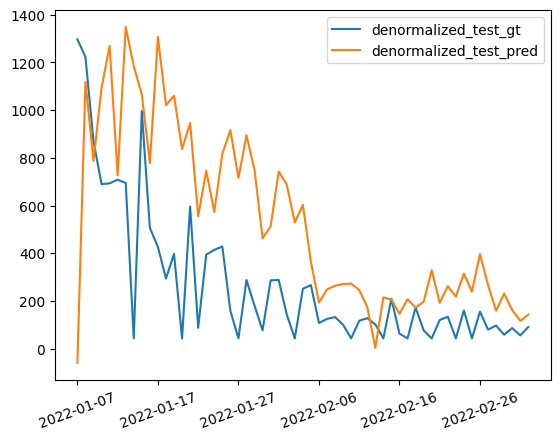

In [113]:
test_pred = model.predict(np.array([x[2].reshape(7,20) for x in test]))
test_pred = pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt = pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])

# Denormalize now
denormalized_test_pred = denormalize(test_pred, Nigeria_test_imputed)
denormalized_test_gt = denormalize(test_gt, Nigeria_test_imputed)

pd.concat([denormalized_test_gt, denormalized_test_pred], axis=1).plot()
plt.legend(['denormalized_test_gt', 'denormalized_test_pred'])
plt.xticks(rotation=20)

In [114]:
y_actual = denormalized_test_gt['y'].values
y_pred = denormalized_test_pred['yhat'].values

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 429.90741391090575


# **Australia model**
Dropping columns with constant values (low variance) and collinearity with new_cases, similar to previous model construction.

In [115]:
# Drop columns based on work from developing Prophet Multivariate model.
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
Australia_train_imputed = Australia_train_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older',
                                                                  'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
                                                                  'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index',
                                                                  'location', 'continent', 'population', 'total_cases_per_million', 'total_cases',
                                                                  'new_cases_per_million', 'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Australia_train_imputed['new_cases_Lag_7'] = Australia_train_imputed['new_cases_Lag_7'].fillna(0)
Australia_train_imputed['new_cases_Lag_14'] = Australia_train_imputed['new_cases_Lag_14'].fillna(0)
Australia_train_imputed["Weekend"] = Australia_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
Australia_test_imputed = Australia_test_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older',
                                                                  'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
                                                                  'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index',
                                                                  'location', 'continent', 'population', 'total_cases_per_million', 'total_cases',
                                                                  'new_cases_per_million', 'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])
# Ensuring that the lag column values in test dataset are those of last values in train
Australia_test_imputed['new_cases_Lag_7'][0:7] = Australia_train_imputed['new_cases'][-7:]
Australia_test_imputed['new_cases_Lag_14'][0:14] = Australia_train_imputed['new_cases'][-14:]
Australia_test_imputed["Weekend"] = Australia_test_imputed["Weekend"].astype(int)

In [116]:
new_cases_mean = Australia_train_imputed['new_cases'].mean()
new_cases_std = Australia_train_imputed['new_cases'].std()

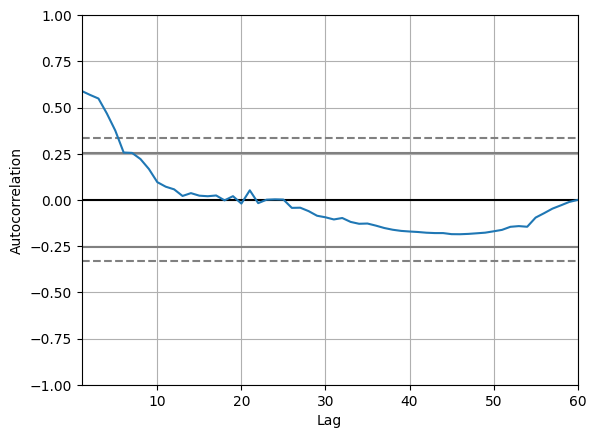

In [117]:
# Prepare for normalization and sequencing

# Plot autocorrelation for a more reasonable number of lags
autocorrelation_plot(Nigeria_train_imputed['new_cases'].iloc[:60])
plt.show()

# 7, 14, 30 and 60 look like a reasonable lag to capture weekly seasonality. The best one was 14.

In [118]:
# Sequence and normalize the data

def process(df):
    #lag7df = df.shift(7)
    lag14df = df.shift(14)
    #lag30df = df.shift(30)
    #lag7df.columns = ['lag7_' + str(col) for col in lag7df.columns]
    lag14df.columns = ['lag14_' + str(col) for col in lag14df.columns]
    #lag30df.columns = ['lag30_' + str(col) for col in lag30df.columns]
    df = df[['new_cases']].join(lag14df)#.join(lag30df)
    return df.fillna(0)

def normalize(df):
    for col in df.columns:
        # if col != 'new_cases':
        df[col]=(df[col]-df[col].mean())/df[col].std()
    return df

Australia_train_imputed = process(Australia_train_imputed)
Australia_train_imputed = normalize(Australia_train_imputed)
Australia_test_imputed = process(Australia_test_imputed)
Australia_test_imputed = normalize(Australia_test_imputed)

In [119]:
# Create make_series function which will give us shape of sequence
def make_series(df):
    series = []
    for i in range(len(df) - 14):
        subdf = df[i:i+14]
        series.append((subdf.index[-1], subdf['new_cases'].values[-1], subdf.drop('new_cases', axis=1).values))
    return series
train = make_series(Australia_train_imputed)
test = make_series(Australia_test_imputed)
print(train[0][0],train[0][1].shape,train[0][2].shape)

2020-02-08 () (14, 35)


In [120]:
# Model construction
from keras.models import Sequential
from keras.layers import LSTM, Dense

inputs = keras.layers.Input(shape=(14, 35))
lstm_out = keras.layers.LSTM(32)(inputs) # 32 is part of the LSTM structure. This is the number of units in the LSTM. The higher the number, the more complicated the nest. Potential for corss validation (ie. Grid or Randomized Search) for optimal hyperparamter tuning.
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 14, 35)]          0         
                                                                 
 lstm_10 (LSTM)              (None, 32)                8704      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8737 (34.13 KB)
Trainable params: 8737 (34.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [121]:
# Model construction continued. Used example values from Professor Shi's code for first batch test: learning_rate = 0.01, batch_size = 32, epochs = 100, sequence_length = 14
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

x=np.array([x[2].reshape(14,35) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=100,
    batch_size=32,
    shuffle=True,
)

(692, 14, 35)
(692,)
Epoch 1/100
22/22 [==============================] - 2s 4ms/step - loss: 0.5120
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 0.5069
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 0.4082
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2972
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2596
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.4279
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 0.2643
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.1806
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 0.1416
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 0.1132
Epoch 11/100
22/22 [==============================] - 0s 4ms/step - loss: 0.1048
Epoch 12/100
22/22 [==============================] - 0s 5ms/step - loss: 0.1159
Epoch 13/100
22/

In [122]:
train_pred = pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train])
train_pred.head()

22/22 [==============================] - 0s 2ms/step


,yhat
2020-02-08,-0.319016
2020-02-09,-0.343727
2020-02-10,-0.254398
2020-02-11,-0.253911
2020-02-12,-0.240183


In [123]:
# Denormalizing function
def denormalize(df, original_df):
    for col in df.columns:
      df[col] = df[col] * new_cases_std + new_cases_mean
      return df

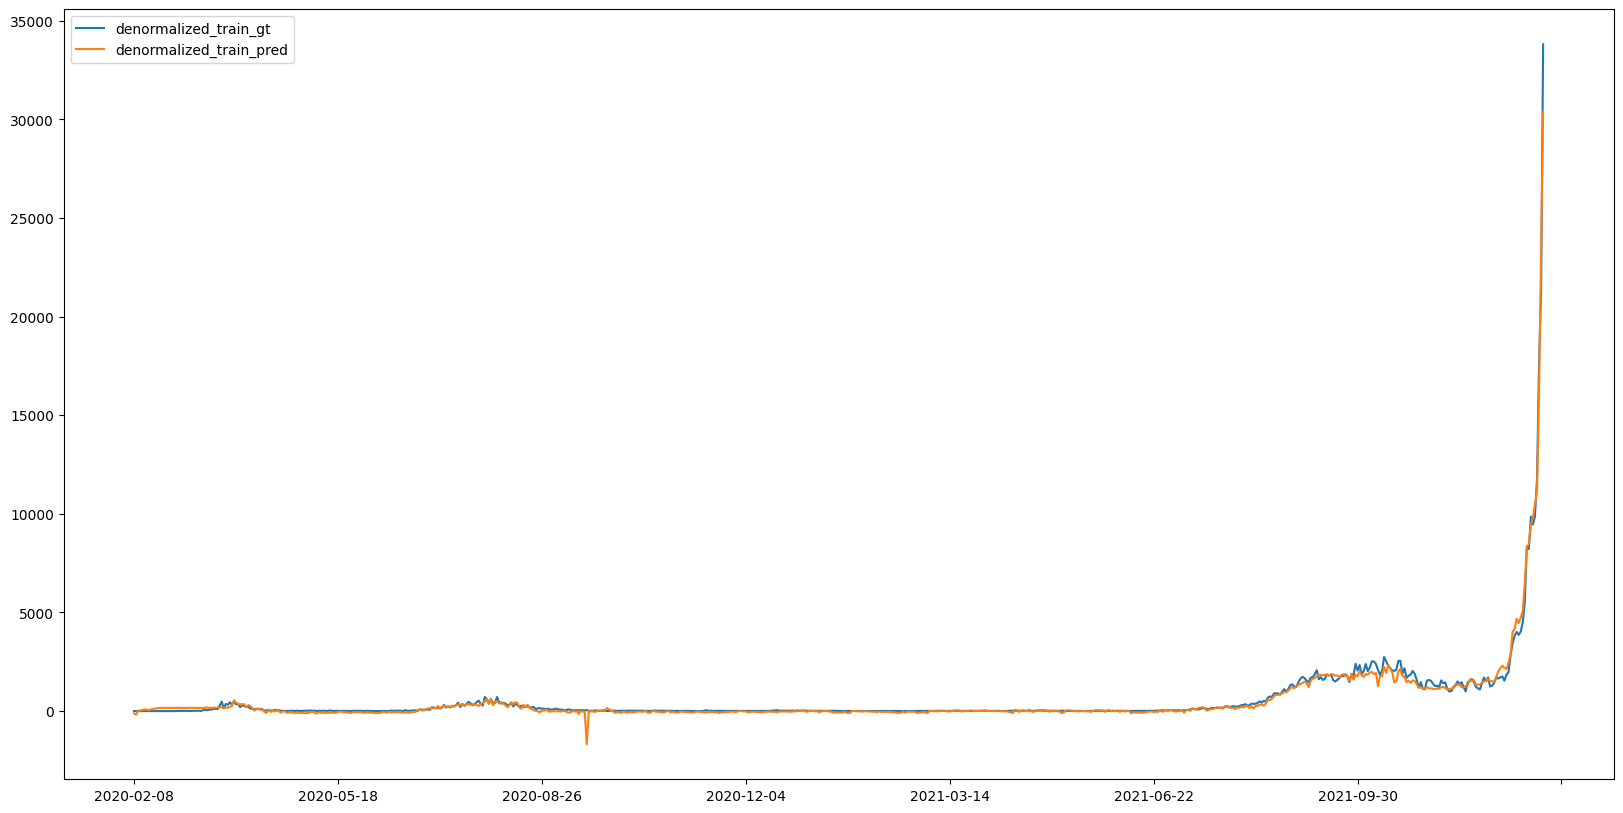

In [124]:
train_gt = pd.DataFrame(y, columns=['y'], index=[x[0] for x in train])

# Denormalize now
denormalized_train_pred = denormalize(train_pred, Australia_train_imputed)
denormalized_train_gt = denormalize(train_gt, Australia_train_imputed)

pd.concat([denormalized_train_gt, denormalized_train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['denormalized_train_gt', 'denormalized_train_pred'])

In [125]:
y_actual = denormalized_train_gt['y'].values
y_pred = denormalized_train_pred['yhat'].values

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("Train RMSE:", train_rmse)

Train RMSE: 233.2160565895115


2/2 [==============================] - 0s 5ms/step


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, '2022-02-23'),
  Text(0.0, 0, '2022-01-14'),
  Text(10.0, 0, '2022-01-24'),
  Text(20.0, 0, '2022-02-03'),
  Text(30.0, 0, '2022-02-13'),
  Text(40.0, 0, '2022-02-23'),
  Text(50.0, 0, ''),
  Text(60.0, 0, '')])

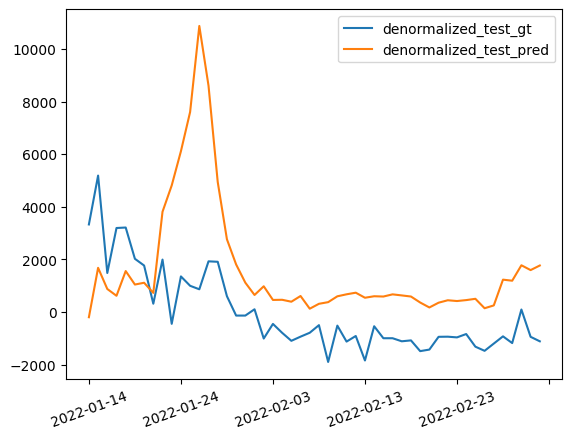

In [126]:
test_pred = model.predict(np.array([x[2].reshape(14,35) for x in test]))
test_pred = pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt = pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])

# Denormalize now
denormalized_test_pred = denormalize(test_pred, Australia_test_imputed)
denormalized_test_gt = denormalize(test_gt, Australia_test_imputed)

pd.concat([denormalized_test_gt, denormalized_test_pred], axis=1).plot()
plt.legend(['denormalized_test_gt', 'denormalized_test_pred'])
plt.xticks(rotation=20)

In [127]:
y_actual = denormalized_test_gt['y'].values
y_pred = denormalized_test_pred['yhat'].values

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 2791.013198359569
